In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from statsmodels.regression import linear_model
# import statsmodels.api as sm
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import warnings

#a bunch of imports!
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

# Text Processing
import string
import nltk
import re 
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer


# Lemmatization

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Imbalance learning
from sklearn.utils import resample

# Model Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/wellswang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Advanced ML Modelling

Using the baseline models and model evaluation strategy you built in the previous part, we will springboard into advanced model building, optimization, evaluation and interpretation. Here are the steps:
- Create a pipeline for tokenization, scaling, and imbalanced learning
- Implement the pipeline for hyperparameter optimization with baseline model
- Apply the methods to other ML models

## Input Features

Finally, we will continue with feature engineering our variables.

In [5]:
# Read if start from here
prod_df= pd.read_csv('data/prod_df.csv')

### Vectorization

We have a product description column, we can vectorize this feature for modelling. Here we will also vectorize the product name.

In [7]:
# One-Hot Encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']
df_encoded = pd.get_dummies(prod_df, columns=categorical_columns, drop_first=True)
df_encoded.shape

# Spliting features X and target y (Reviewer Score)
X = df_encoded.drop('trending', axis=1)
y = df_encoded['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

(28962, 131) (7241, 131)


Let's split the X_train, X_test into positive reviews, negative reviews, and other.

In [8]:
# Splitting X_train and X_test into desired 3 tables
X_train_name = X_train['prod_name']
X_train_desc = X_train['detail_desc']
X_train_og = X_train.drop(columns=['prod_name', 'detail_desc'], axis=1)

X_test_name = X_test['prod_name']
X_test_desc = X_test['detail_desc']
X_test_og = X_test.drop(columns=['prod_name', 'detail_desc'], axis=1)

Now that we have them separated, we can continue to deal with the reviews and leave the others aside for now. 

In [9]:
X_train_name.value_counts(sort=True, ascending=False)[0:10]

prod_name
Molly dress         7
Bella dress         6
Dolly dress         6
Bowie               6
Ruby                6
Daisy               6
Melrose             6
Rose                5
Presley PU skirt    5
Cora                5
Name: count, dtype: int64

In [10]:
X_train_desc.value_counts(sort=True, ascending=False)[0:10]

detail_desc
                                                                                                          100
T-shirt in printed cotton jersey.                                                                          18
Boxer shorts in a cotton weave with an elasticated waist, long legs and button fly.                        12
Leggings in soft cotton jersey with an elasticated waist.                                                  12
T-shirt in soft cotton jersey with a print motif on the front.                                             10
T-shirt in cotton jersey with a print motif on the front.                                                  10
Leggings in soft organic cotton jersey with an elasticated waist.                                          10
Trunks in stretch cotton jersey with flatlock seams, short legs, an elasticated waist and lined front.     10
Boxer shorts in cotton jersey with short legs, an elasticated waist and lined front.                       1

Let's get our custom tokenizer.

**Tokenizer - Custom - Lemmatization**

In [11]:
# Custom tokenizer using lemmatizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


lemmatizer = WordNetLemmatizer()

ENGLISH_STOP_WORDS = stopwords.words('english')
# Include words we want to clean in stop words
# ENGLISH_STOP_WORDS.extend(['none','no', 'nothing','n','a','negative','positive'])

def my_lemma_tokenizer(sentence):
    # # remove punctuation, numbers, and set to lower case
    # sentence = re.sub(r'[^a-zA-Z\s]', '', sentence).lower()
    
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    pos_tags = nltk.pos_tag(listofwords)
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word, tag in pos_tags:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lemmatized words
            
            lemmatized_word = lemmatizer.lemmatize(word,get_wordnet_pos(tag))
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

## Imbalanced Learning

Since our data is imbalanced, it would be better if we had introduce some upsampling to our dataset.

### SMOTE

In [49]:
# Upsampling with SMOTE
from imblearn.over_sampling import SMOTE
sampler = SMOTE(random_state=123)
X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
print(X_train_res.shape, y_train_res.shape)

(51792, 1129) (51792,)


**Fitting the Model**

In [50]:
# Standard scaling the features
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train_res)
X_test_ss = scaler.transform(X_test)

# Fitting the model
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train_ss, y_train_res)

# Training and test score
print(f"Train score: {logreg.score(X_train_ss, y_train_res)}")
print(f"Test score: {logreg.score(X_test_ss, y_test)}")

Train score: 0.8692269076305221
Test score: 0.8091423836486673


**Evaluating the Model**

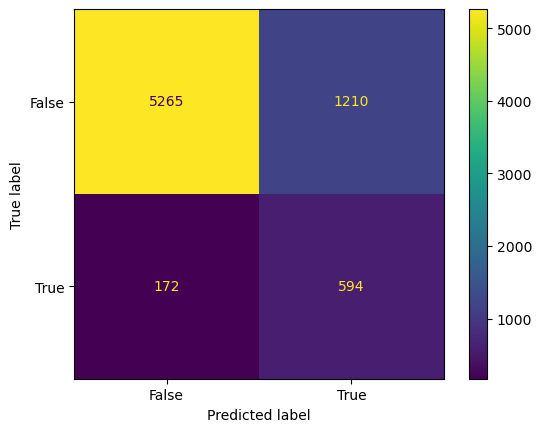

In [51]:
# Evaluate with confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test_ss, y_test)
plt.show()

In [52]:
# evaluate on the original test set
y_pred = logreg.predict(X_test_ss)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.81      0.88      6475
        True       0.33      0.78      0.46       766

    accuracy                           0.81      7241
   macro avg       0.65      0.79      0.67      7241
weighted avg       0.90      0.81      0.84      7241



- Here we can see that we have a more satisfactory recall score, we can detect 78% of the trending items with this baseline model!

In [53]:
def false_positive_rate(y_true, y_pred):
    
    false_positives = (y_true == 0) & (y_pred == 1) # find all values where y is negative
                                                    # but we predicted positive
    false_positive_number = false_positives.sum()

    true_negatives = (y_true == 0) & (y_pred == 0)  # find all values where y is negative
                                                    # and we predicted negative
    true_negative_number = true_negatives.sum()

    # Finally, find the ratio of (FP) to (TN + FP)
    FPR = false_positive_number/(true_negative_number + false_positive_number)
    
    return FPR
fpr = false_positive_rate(y_test, y_pred)
fpr

0.18687258687258687

## Pipe

In [86]:
# Spliting features X and target y (Reviewer Score)
X = prod_df.drop('trending', axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [('desc', TfidfVectorizer(max_features=200, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'detail_desc'),
                  ('name', TfidfVectorizer(max_features=200, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'prod_name'),
                  ('normalise', StandardScaler(), ['unit_price']),
                  ('cat', OneHotEncoder(drop='first'), categorical_columns)
                 ]


# Create the column transformer
col_trans = ColumnTransformer(col_transforms)

(28962, 9) (7241, 9)


In [87]:
# Apply the transformations
X_train = col_trans.fit_transform(X_train) 
X_test = col_trans.transform(X_test)

# Put in a DataFrame
transformed_df = pd.DataFrame(X_train.todense(), columns=col_trans.get_feature_names_out())
transformed_df.head()

,desc__5pocket,desc__adjustable,desc__adjustable shoulder,desc__adjustable shoulder strap,desc__airy,desc__anklelength,desc__around,desc__around neckline,desc__around neckline cuff,desc__back,...,cat__graphical_appearance_name_Other pattern,cat__graphical_appearance_name_Other structure,cat__graphical_appearance_name_Placement print,cat__graphical_appearance_name_Sequin,cat__graphical_appearance_name_Slub,cat__graphical_appearance_name_Solid,cat__graphical_appearance_name_Stripe,cat__graphical_appearance_name_Transparent,cat__graphical_appearance_name_Treatment,cat__graphical_appearance_name_Unknown
0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.09945,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.251879,0.321534,0.321534,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# with default vectorizer

In [85]:
# Spliting features X and target y (Reviewer Score)
X = prod_df.drop('trending', axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [('desc', TfidfVectorizer(), 'detail_desc'),
                  ('name', TfidfVectorizer(), 'prod_name'),
                  ('normalise', StandardScaler(), ['unit_price']),
                  ('cat', OneHotEncoder(drop='first'), categorical_columns)
                 ]

# Create the column transformer
col_trans = ColumnTransformer(col_transforms)

(28962, 9) (7241, 9)


In [83]:
# Apply the transformations
X_train = col_trans.fit_transform(X_train) 
X_test = col_trans.transform(X_test)

# Put in a DataFrame
transformed_df = pd.DataFrame(X_train.todense(), columns=col_trans.get_feature_names_out())
transformed_df.head()

,desc__0241590,desc__0391750,desc__0391772,desc__0451290,desc__0504415,desc__0504416,desc__0507864,desc__0518647,desc__0533000,desc__0575442,...,cat__graphical_appearance_name_Other pattern,cat__graphical_appearance_name_Other structure,cat__graphical_appearance_name_Placement print,cat__graphical_appearance_name_Sequin,cat__graphical_appearance_name_Slub,cat__graphical_appearance_name_Solid,cat__graphical_appearance_name_Stripe,cat__graphical_appearance_name_Transparent,cat__graphical_appearance_name_Treatment,cat__graphical_appearance_name_Unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The new feature names are contained in the fitted transformer as we saw before with FeatureUnion:

Now we can apply the transformation and create a new DataFrame:

In [44]:
transformed_df.shape

(28962, 1127)

# together

In [102]:
from sklearn.pipeline import Pipeline

# Spliting features X and target y (Reviewer Score)
X = prod_df.drop(['trending', 'product_id'], axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [('desc', TfidfVectorizer(max_features=50, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'detail_desc'),
                  ('name', TfidfVectorizer(max_features=50, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'prod_name'),
                  ('normalise', StandardScaler(), ['unit_price']),
                  ('cat', OneHotEncoder(drop='first'), categorical_columns)
                 ]

# Create the column transformer
col_trans = ColumnTransformer(col_transforms)


#we give our estimators as a list of tuples: name:function.
estimators = [('feature_eng', col_trans),
              ('smote', SMOTE(random_state=123)),
              ('logreg', LogisticRegression(random_state=123))
             ] #Step3 -> Calssifier

pipe = ImbPipeline(estimators)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

(28962, 8) (7241, 8)
              precision    recall  f1-score   support

       False       0.98      0.74      0.84      6475
        True       0.28      0.86      0.42       766

    accuracy                           0.75      7241
   macro avg       0.63      0.80      0.63      7241
weighted avg       0.90      0.75      0.80      7241



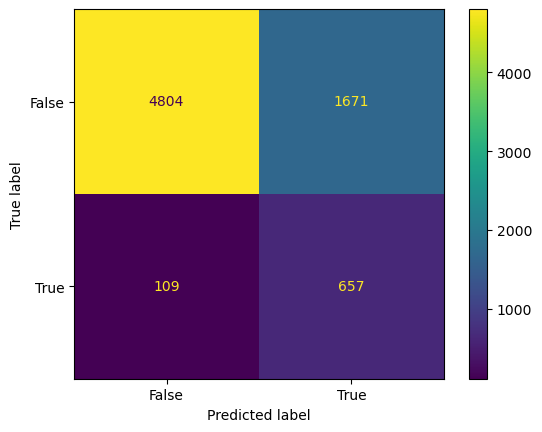

In [103]:
# Evaluate with confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

In [99]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
# Upsampling with SMOTE
from imblearn.over_sampling import SMOTE

# Spliting features X and target y (Reviewer Score)
X = prod_df.drop(['trending', 'product_id'], axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)


# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [('desc', TfidfVectorizer(), 'detail_desc'),
                  ('name', TfidfVectorizer(), 'prod_name'),
                  ('normalise', StandardScaler(), ['unit_price']),
                  ('cat', OneHotEncoder(drop='first'), categorical_columns)
                 ]

# Create the column transformer
col_trans = ColumnTransformer(col_transforms)


#we give our estimators as a list of tuples: name:function.
estimators = [('feature_eng', col_trans),
              ('smote', SMOTE(random_state=123)),
              ('logreg', LogisticRegression(random_state=123))
             ] #Step3 -> Calssifier

pipe = ImbPipeline(estimators)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

(28962, 8) (7241, 8)
              precision    recall  f1-score   support

       False       0.97      0.85      0.90      6475
        True       0.37      0.75      0.49       766

    accuracy                           0.84      7241
   macro avg       0.67      0.80      0.70      7241
weighted avg       0.90      0.84      0.86      7241



In [66]:
prod_df.head()

,product_id,prod_name,detail_desc,product_type_name,product_group_name,index_group_name,section_name,graphical_appearance_name,unit_price,trending
0,541518,Rae Push (Melbourne) 2p,"Lace push-up bras with underwired, moulded, pa...",Bra,Underwear,Ladieswear,Womens Lingerie,Solid,0.030492,True
1,663713,Atlanta Push Body Harlow,"Lace push-up body with underwired, moulded, pa...",Underwear body,Underwear,Ladieswear,Womens Lingerie,Solid,0.050831,False
2,505221,Inca Jumper,Jumper in rib-knit cotton with hard-worn detai...,Sweater,Garment Upper body,Divided,Divided Selected,Melange,0.020322,False
3,685687,W YODA KNIT OL OFFER,V-neck knitted jumper with long sleeves and ri...,Sweater,Garment Upper body,Ladieswear,Womens Everyday Collection,Melange,0.016932,True
4,501323,Thomas paperbag wide,"Trousers in woven fabric with a high, paper ba...",Trousers,Garment Lower body,Ladieswear,Womens Tailoring,Check,0.059305,True


In [70]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36203 entries, 0 to 36202
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 36203 non-null  int64  
 1   prod_name                  36203 non-null  object 
 2   detail_desc                36203 non-null  object 
 3   product_type_name          36203 non-null  object 
 4   product_group_name         36203 non-null  object 
 5   index_group_name           36203 non-null  object 
 6   section_name               36203 non-null  object 
 7   graphical_appearance_name  36203 non-null  object 
 8   unit_price                 36203 non-null  float64
 9   trending                   36203 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 2.5+ MB
